In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, make_scorer, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
# Be sure that final script is absolutely one level down repo root directory (e.g. /scripts/)
cwd = Path.cwd()
appdir = cwd.parents[0]
model_path = appdir/"model"
lncrna_path = appdir/"lncrna"
not_lncrna_path = appdir/"not_lncrna"

In [3]:
lncrna=pd.read_csv(model_path/'X_train_lncrna.csv')
lncrna["lncRNA"] = True
not_lncrna=pd.read_csv(model_path/'X_train_not_lncrna.csv')
not_lncrna["lncRNA"] = False
lncrna.drop(["mfe"], axis=1, inplace=True)
not_lncrna.drop(["none"], axis=1, inplace=True)
features = pd.DataFrame({})
features = pd.concat([lncrna, not_lncrna], ignore_index=True)
features.sort_values(ascending=True, by=["start", "end", "name"], inplace=True)
features_clean = features.dropna(axis=0, how="any")
dropped = 1 - len(features_clean) / len(features)
print('Dropped ' + str(round(dropped, 3) * 100) + '% of rows from the original dataset due to NA values')
X = features_clean.iloc[:,3:14].values
y = features_clean.iloc[:,-1].values

Dropped 2.5% of rows from the original dataset due to NA values


## Finding best parameters for the Random Forest Classifier

In [32]:
rf = RandomForestClassifier(random_state=15)
param_grid = {
    'n_estimators' : [10, 25, 50, 100],
    'max_depth' : [3, 5, 7, 9],
    'min_samples_split' : [2, 4, 6, 8, 10],
    'min_samples_leaf' : [1, 2, 5, 10]
}
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'AUC': 'roc_auc',
    'Accuracy': make_scorer(accuracy_score), 
    'Precision': make_scorer(precision_score)}
gs = GridSearchCV(rf, param_grid, verbose=3, n_jobs=-1, scoring='precision')
gs.fit(X, y)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=15), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='precision', verbose=3)

In [23]:
results = gs.cv_results_
gs.best_estimator_

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=15)

In [38]:
rf_best = RandomForestClassifier(n_estimators=10, max_depth=3, n_jobs=-1)

from sklearn.model_selection import train_test_split
Xtr, Xts, Ytr, Yts = train_test_split(X, y, random_state=15)
Xtr.shape, Xts.shape, Ytr.shape, Yts.shape

((172749, 11), (57584, 11), (172749,), (57584,))

In [39]:
rf_best.fit(Xtr, Ytr)
Ypr = rf_best.predict(Xts)
print(accuracy_score(Yts, Ypr))
print(precision_score(Yts, Ypr))
print(recall_score(Yts, Ypr))
print(f1_score(Yts, Ypr))
print(roc_auc_score(Yts, Ypr))

0.967022089469297
0.0
0.0
0.0
0.5


AttributeError: type object 'RocCurveDisplay' has no attribute 'from_estimator'

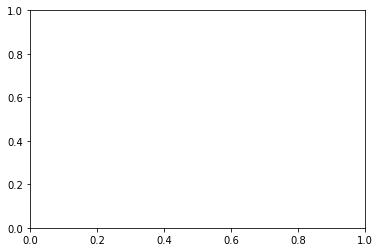

In [31]:
cv = KFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    rf_best.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        rf_best,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()